## Minimising the Action of a Discrete Path via Gradient Descent

In [38]:
import jax.numpy as jnp
from jax import random, jit
import jax
import matplotlib.pyplot as plt
import optax
from functools import partial
import loss_functions as lf
from action_functions import harmonic_potential, compute_action, fourier_basis_expansion

### Basic Parameters

In [39]:
# ------ physical parameters ------

t_a, t_b = [0, 1] # time interval
N = 100 # number of time steps
time_array = jnp.linspace(t_a, t_b, N) # timesteps
m = 1. # mass
omega = jnp.pi # frequency

# --------- Optimiser Parameters -------------

start_learning_rate = 1e-3      # initial learning rate for Adam optimiser
opt_N = 2500                    # maximum number of optimiser steps before abandoning guess
ad_tol = 1e-3                   # convergence criterion for AD loss function
print_cycle = 10                # how often to print output of AD optimiser

### 1) Generate a random guess in Fourier space

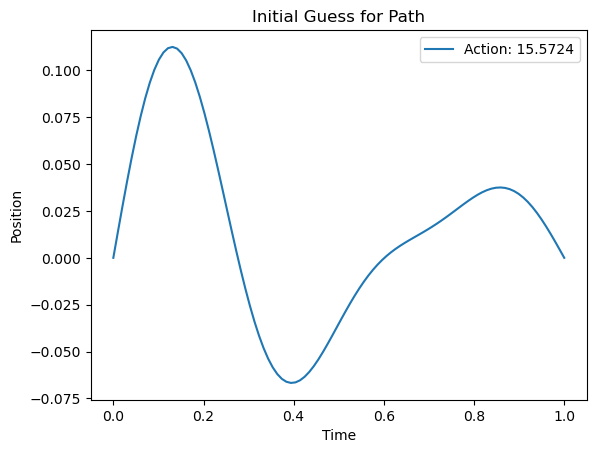

In [40]:
seed = 0
key = random.PRNGKey(seed)
key, subkey = random.split(key)

k = 5 # number of Fourier modes
#coeffs_guess = jnp.array([0.1, 0., 0., 0., 0.]) + random.uniform(subkey, shape=(k,)) * 0.1 # initialising coefficients
coeffs_guess = random.uniform(subkey, shape=(k,)) * 0.1 # initialising coefficients
x_guess = fourier_basis_expansion(coeffs_guess, time_array) # constructing path from Fourier coefficients

# defining system
potential_fn = partial(harmonic_potential, m=m, omega=omega)
action_fn = lambda x: compute_action(x, time_array, m, potential_fn)
action_value = action_fn(x_guess)

plt.plot(time_array, x_guess, label=f'Action: {action_value:.4f}')
plt.title('Initial Guess for Path')
plt.legend(loc='best')
plt.xlabel('Time')
plt.ylabel('Position')
plt.show()

### 2) Converge random guess with AD

In [41]:
# define the function to update the initial random guess

@partial(jit, static_argnames=('m', 'potential'))
def gradfn(params, t_array, alpha, m, potential):
    return jax.value_and_grad(lf.harmonic_loss_function)(params, t_array, alpha, m, potential)

@partial(jit, static_argnames=('m', 'optimiser', 'potential'))
def updatefn(params, t_array, opt_state, optimiser, alpha, m, potential):

    loss, grads = gradfn(params, t_array, alpha, m, potential)

    updates, opt_state = optimiser.update(grads, opt_state)

    params = optax.apply_updates(params, updates)
  
    return params, opt_state, loss

# set up the optimiser

optimizer = optax.adam(start_learning_rate)
opt_state = optimizer.init(coeffs_guess)

# initialise the annealing parameter alpha
alpha = 1.

In [42]:
# Optimisation loop

for i in range(opt_N):

    action_loss = lf.convergence_check(coeffs_guess, time_array, m, potential_fn)

    if i%print_cycle == 0:
        print(i, ": Action Loss = ", action_loss)


    if action_loss < ad_tol:
        print(i, ": Action Loss = ", action_loss)
        print('Converged!')
        break

    coeffs_guess, opt_state, loss = updatefn(coeffs_guess, time_array, opt_state, optimizer, alpha, m, potential_fn)

    alpha -= 1./opt_N                                         # anneal alpha

0 : Action Loss =  15.572421
10 : Action Loss =  8.758409
20 : Action Loss =  4.528387
30 : Action Loss =  2.301574
40 : Action Loss =  1.1556494
50 : Action Loss =  0.5397945
60 : Action Loss =  0.236015
70 : Action Loss =  0.09531186
80 : Action Loss =  0.030930541
90 : Action Loss =  0.007192759
100 : Action Loss =  0.0011732426
101 : Action Loss =  0.0009554682
Converged!


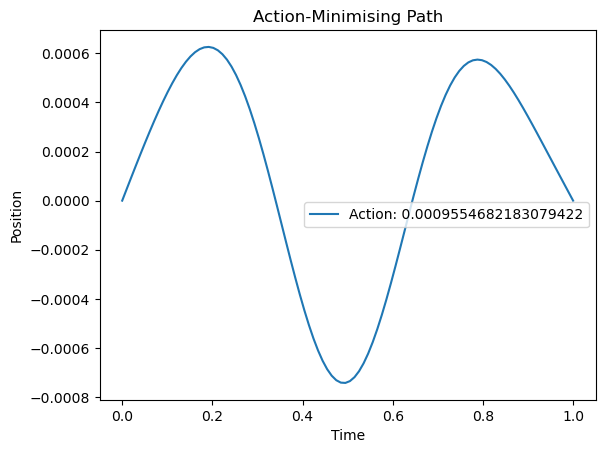

In [43]:
x_constructed = fourier_basis_expansion(coeffs_guess, time_array) # constructing path from Fourier coefficients

# defining system
action_value = action_fn(x_constructed)

plt.plot(time_array, x_constructed, label=f'Action: {action_value}')
plt.title('Action-Minimising Path')
plt.legend(loc='best')
plt.xlabel('Time')
plt.ylabel('Position')
plt.show()

In [ ]:
iter_array = jnp.arange(len(action_array))

plt.plot(iter_array, jnp.log(action_array), label='Action')
plt.plot(iter_array, jnp.log(grad_array), label='Gradient Norm')
plt.title('Log of Action and Gradient Norm over Iterations')
plt.xlabel('Iteration')
plt.legend(loc='best')
plt.show()

In [ ]:
# plt.plot(t_array, x, label='Optimised Path')
plt.plot(t_array, funcs.fourier_basis_expansion(t_array,a_n), label='Optimised Path')
plt.plot(t_array, x_guess, label='Guess Path')
plt.title('Path over Time')
plt.xlabel('Time')
plt.ylabel('Position')
plt.legend(loc='best')
plt.show()